# 프로젝트: 고양이 수염 스티커 만들기
1. face landmark로 이목구비를 찾아 bounding box를 그린다
2. 고양이 수염 스티커 이미지를 가져와 원본 이미지에 적용한다.
3. 각도가 다른 사진으로 회전도를 고려해 스티커 각도를 조절해본다.

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

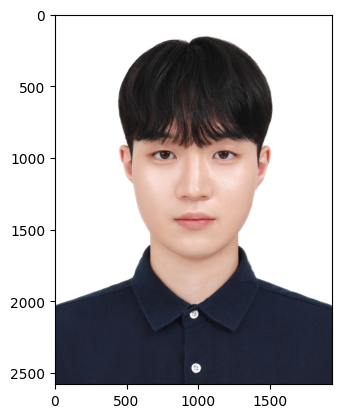

In [2]:
mh_image_path = '/content/kmh.png'
img_bgr = cv2.imread(mh_image_path)
img_show = img_bgr.copy()
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb) # 이미지 실제 출력하기 위해 이미지를 올려줌 (원하는 사이즈의 픽셀을 원하는 색으로 채워서 만든 그림이라고 합니다.)
plt.show()

In [3]:
# detector를 선언합니다
detector_hog = dlib.get_frontal_face_detector()

# bounding box 추출
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)

rectangles[[(510, 724) (1469, 1682)]]


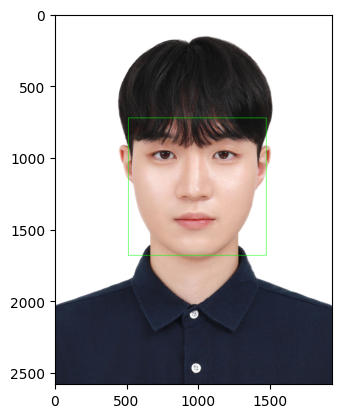

In [4]:
# 찾은 얼굴 영역 박스 리스트
print(dlib_rects)

for dlib_rect in dlib_rects: # 찾은 얼굴 영역의 좌표
    l = dlib_rect.left() # 왼쪽
    t = dlib_rect.top() # 위쪽
    r = dlib_rect.right() # 오른쪽
    b = dlib_rect.bottom() # 아래쪽

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA) # 시작점의 좌표와 종료점 좌표로 직각 사각형을 그림

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### face landmark
이목구비의 위치를 추론하는 것. 객체 내부의 점을 찾는 기술

**Object keypoint estimation 알고리즘**

Face landmark와 같이 객체 내부의 점을 찾는 기술을 object keypoint estimation이라고 합니다.

1) top-down : bounding box를 찾고 box 내부의 keypoint를 예측

In [5]:
# landmark 모델 불러오기
model_path = '/content/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

# 랜드마크의 위치를 저장할 list 생성
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark 좌표를 저장
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


### 랜드마크를 영상에 출력

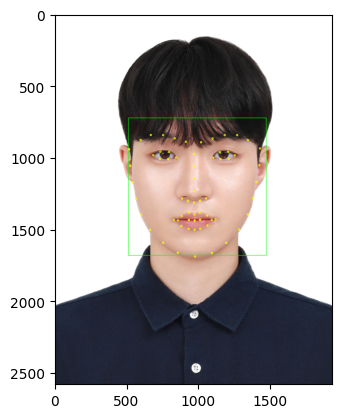

In [6]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 5, (0, 255, 255), 3) # 선이 너무 연해서 짙게 표현

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### 스티커 적용하기

In [7]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # 코 index 30
    x = landmark[30][0] # 이미지에서 코 부위의 x값
    y = landmark[30][1] # 이미지에서 코 부위의 y값 - 얼굴 영역의 세로를 차지하는 픽셀의 수//2
    w = h = dlib_rect.width() # 얼굴 영역의 가로를 차지하는 픽셀의 수(픽셀 수 하나는 점:1)
    print (f'(x,y) : ({x},{y})')
    print (f'(w,h) : ({w},{h})')

(966, 1234)
(x,y) : (966,1234)
(w,h) : (960,960)


In [8]:
# 스티커 이미지 불러오기
sticker_path = '/content/cat-whiskers.png' # 고양이 수염 이미지 경로
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(960, 960, 3)


In [9]:
# 원본 이미지 -> 스티커 이미지 추가를 하기 위한 좌표 조정
refined_x = x - w // 2
refined_y = y - h // 2
print (f'(x,y) : ({refined_x},{refined_y})')

# 이미지에 벗어날 것을 고려
if refined_x < 0:
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

(x,y) : (486,754)


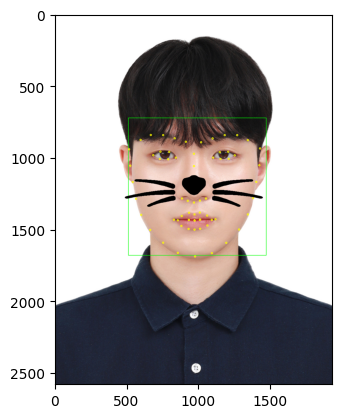

In [10]:
# 원본 이미지에 스티커 적용
weight = img_sticker.shape[0]
height = img_sticker.shape[1]

sticker_area = img_show[refined_y:refined_y + weight, refined_x:refined_x + height]
img_show[refined_y:refined_y + weight, refined_x:refined_x + height] = \
    np.where(img_sticker==0, img_sticker, sticker_area).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

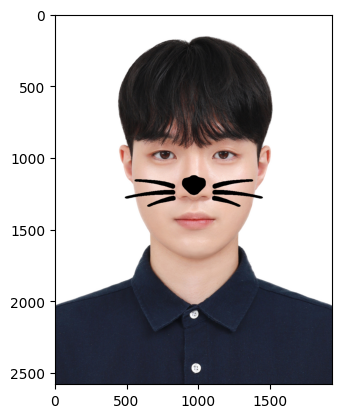

In [11]:
sticker_area = img_bgr[refined_y:refined_y + weight, refined_x:refined_x + height]

img_bgr[refined_y:refined_y + weight, refined_x:refined_x + height] = \
    np.where(img_sticker==0, img_sticker, sticker_area).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

### 반투명 이미지

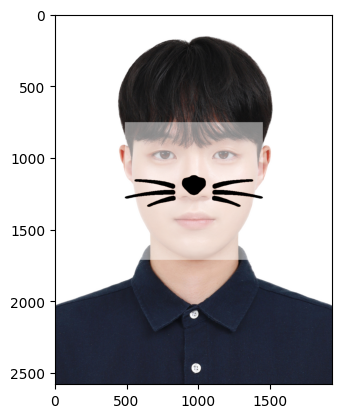

In [12]:
sticker_area = img_bgr[refined_y:refined_y+weight, refined_x:refined_x+height]
img_bgr[refined_y:refined_y+weight, refined_x:refined_x+height] = \
    cv2.addWeighted(sticker_area, 0.5, np.where(img_sticker==255, img_sticker, sticker_area).astype(np.uint8), 0.5, 0)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

#### 아무리해도 반투명이 되지 않는다 왜일까??

- 스티커의 배경을 제거할 때, 알파 채널 또는 마스크 처리가 완벽하지 않으면 여전히 배경이 남아 있을 수 있다고 한다. 특히 np.where()가 배경을 제대로 인식하지 못하고 있을 수 있어서 배경 제거가 제대로 안 되고 있을 가능성이 있다. 또한 np.where()와 cv2.addWeighted()의 역할이 중복되어 적절히 조합하는 것이 중요하다고 한다.

## 회전도 고려해보기
- 셀카 각도에 따른 스티커 각도 조절

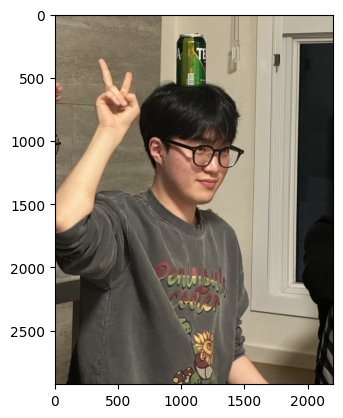

In [13]:
mh2_image_path = '/content/kmh2.png'
img2_bgr = cv2.imread(mh2_image_path)
img2_show = img2_bgr.copy()
img2_rgb = cv2.cvtColor(img2_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img2_rgb) # 이미지 실제 출력하기 위해 이미지를 올려줌 (원하는 사이즈의 픽셀을 원하는 색으로 채워서 만든 그림이라고 합니다.)
plt.show()

In [14]:
# detector를 선언합니다
detector_hog2 = dlib.get_frontal_face_detector()

# bounding box 추출
img2_rgb = cv2.cvtColor(img2_bgr, cv2.COLOR_BGR2RGB)
dlib_rects2 = detector_hog2(img2_rgb, 1)

rectangles[[(911, 911) (1466, 1466)]]


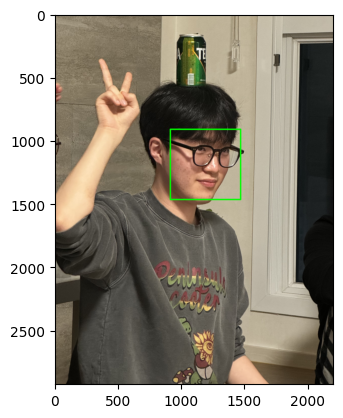

In [15]:
# 찾은 얼굴 영역 박스 리스트
print(dlib_rects2)

for dlib_rect2 in dlib_rects2: # 찾은 얼굴 영역의 좌표
    l = dlib_rect2.left() # 왼쪽
    t = dlib_rect2.top() # 위쪽
    r = dlib_rect2.right() # 오른쪽
    b = dlib_rect2.bottom() # 아래쪽

    cv2.rectangle(img2_show, (l,t), (r,b), (0,255,0), 10, lineType=cv2.LINE_AA) # 시작점의 좌표와 종료점 좌표로 직각 사각형을 그림

img2_show_rgb =  cv2.cvtColor(img2_show, cv2.COLOR_BGR2RGB)
plt.imshow(img2_show_rgb)
plt.show()

In [16]:
model_path2 = '/content/shape_predictor_68_face_landmarks.dat'
landmark_predictor2 = dlib.shape_predictor(model_path2)

# 랜드마크의 위치를 저장할 list 생성
list2_landmarks = []  # list2_landmarks에 저장하도록 수정

# 얼굴 영역 박스 마다 face landmark 좌표를 저장
for dlib_rect2 in dlib_rects2:
    points2 = landmark_predictor2(img2_rgb, dlib_rect2)  # landmark_predictor2 사용
    list2_points = list(map(lambda p: (p.x, p.y), points2.parts()))
    list2_landmarks.append(list2_points)  # list2_landmarks에 저장하도록 수정

# 첫 번째 얼굴의 랜드마크 수를 출력
if list2_landmarks:
    print(len(list2_landmarks[0]))  # 첫 번째 얼굴의 랜드마크 좌표 출력
else:
    print("list2_landmarks가 비어 있습니다.")

68


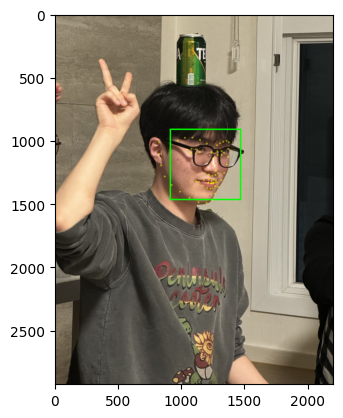

In [17]:
# 랜드마크를 영상에 출력
for landmark2 in list2_landmarks:
    for point2 in landmark2:
        cv2.circle(img2_show, point2, 5, (0, 255, 255), 2)

img2_show_rgb = cv2.cvtColor(img2_show, cv2.COLOR_BGR2RGB)
plt.imshow(img2_show_rgb)
plt.show()

In [18]:
for dlib_rect2, landmark2 in zip(dlib_rects2, list2_landmarks):
    print (landmark2[30]) # 코 index 30
    x = landmark2[30][0] # 이미지에서 코 부위의 x값
    y = landmark2[30][1] # 이미지에서 코 부위의 y값 - 얼굴 영역의 세로를 차지하는 픽셀의 수//2
    w = h = dlib_rect2.width() # 얼굴 영역의 가로를 차지하는 픽셀의 수(픽셀 수 하나는 점:1)
    print (f'(x,y) : ({x},{y})')
    print (f'(w,h) : ({w},{h})')

(1269, 1237)
(x,y) : (1269,1237)
(w,h) : (556,556)


In [19]:
# 스티커 이미지 불러오기
sticker2_path = '/content/cat-whiskers.png' # 고양이 수염 이미지 경로
img2_sticker = cv2.imread(sticker2_path)
img2_sticker = cv2.resize(img2_sticker, (w,h))
print (img2_sticker.shape)

(556, 556, 3)


In [20]:
# 원본 이미지 -> 스티커 이미지 추가를 하기 위한 좌표 조정
refined2_x = x - w // 2
refined2_y = y - h // 2
print (f'(x,y) : ({refined2_x},{refined2_y})')

# 이미지에 벗어날 것을 고려
if refined2_x < 0:
    img2_sticker = img2_sticker[:, -refined2_x:]
    refined2_x = 0
if refined2_y < 0:
    img2_sticker = img2_sticker[-refined2_y:, :]
    refined2_y = 0

(x,y) : (991,959)


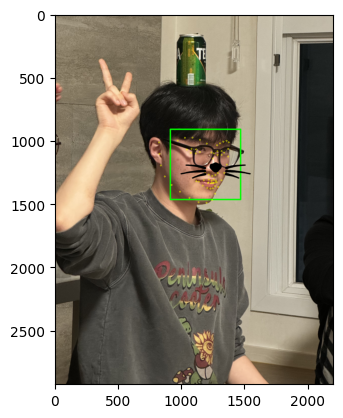

In [21]:
# 원본 이미지에 스티커 적용
weight2 = img2_sticker.shape[0]
height2 = img2_sticker.shape[1]

sticker2_area = img2_show[refined2_y:refined2_y + weight2, refined2_x:refined2_x + height2]
img2_show[refined2_y:refined2_y + weight2, refined2_x:refined2_x + height2] = \
    np.where(img2_sticker==0, img2_sticker, sticker2_area).astype(np.uint8)

plt.imshow(cv2.cvtColor(img2_show, cv2.COLOR_BGR2RGB))
plt.show()

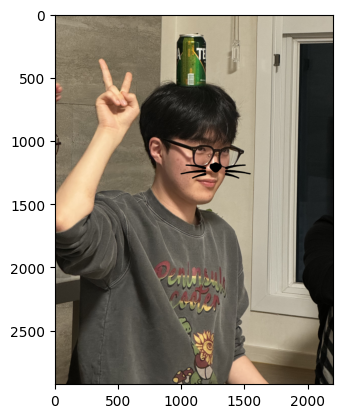

In [22]:
# 랜드마크 제거
sticker2_area = img2_bgr[refined2_y:refined2_y + weight2, refined2_x:refined2_x + height2]

img2_bgr[refined2_y:refined2_y + weight2, refined2_x:refined2_x + height2] = \
    np.where(img2_sticker==0, img2_sticker, sticker2_area).astype(np.uint8)

plt.imshow(cv2.cvtColor(img2_bgr, cv2.COLOR_BGR2RGB))
plt.show()

### 스티커 객체 90도 회전하기
1. cv2.rotate() 함수로 회전하기
2. cv2.getRotationMatrix2D() 함수로 회전하기

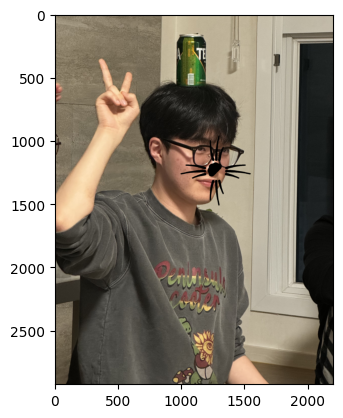

In [23]:
# 1. cv2.rotate() 함수로 90도 회전해보기

# 스티커 객체를 90도 회전 (반시계방향 90도)
img2_sticker_rotated = cv2.rotate(img2_sticker, cv2.ROTATE_90_COUNTERCLOCKWISE)

# 스티커가 들어갈 영역 크기 확인
h, w = img2_sticker_rotated.shape[:2]  # 회전된 스티커의 크기

# 스티커가 들어갈 영역 업데이트
sticker2_area = img2_bgr[refined2_y:refined2_y + h, refined2_x:refined2_x + w]

# 회전된 스티커를 원본 이미지에 합성 (배경 제거)
img2_bgr[refined2_y:refined2_y + h, refined2_x:refined2_x + w] = \
    np.where(img2_sticker_rotated == 0, img2_sticker_rotated, sticker2_area).astype(np.uint8)

# 결과 이미지 출력
plt.imshow(cv2.cvtColor(img2_bgr, cv2.COLOR_BGR2RGB))
plt.show()

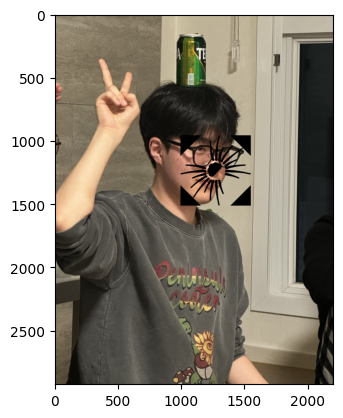

In [24]:
# 2. cv2.getRotationMatrix2D() 함수로 회전하기

center = (img2_sticker.shape[1] // 2, img2_sticker.shape[0] // 2)
angle = 45  # 원하는 회전 각도
scale = 1.0

# 회전 행렬 생성
rotation_matrix = cv2.getRotationMatrix2D(center, angle, scale)

# 스티커 회전 적용
img2_sticker_rotated = cv2.warpAffine(img2_sticker, rotation_matrix, (img2_sticker.shape[1], img2_sticker.shape[0]))

# 회전된 스티커를 원본 이미지에 합성
sticker2_area = img2_bgr[refined2_y:refined2_y + img2_sticker_rotated.shape[0], refined2_x:refined2_x + img2_sticker_rotated.shape[1]]

img2_bgr[refined2_y:refined2_y + img2_sticker_rotated.shape[0], refined2_x:refined2_x + img2_sticker_rotated.shape[1]] = \
    np.where(img2_sticker_rotated == 0, img2_sticker_rotated, sticker2_area).astype(np.uint8)

# 결과 이미지 출력
plt.imshow(cv2.cvtColor(img2_bgr, cv2.COLOR_BGR2RGB))
plt.show()

### 회고

이미지로 이렇게 detection 하고 스티커를 적용하는 것이 되게 재밌었던 것 같다. 다양한 시도를 해보려 했지만, 시간이 없어서 학습이 끝나고 더 해보려고 한다!